## データ情報

In [1]:
from nltk.corpus.util import LazyCorpusLoader
from nltk.corpus.reader import *

# コーパスのロード
ma_reuters = LazyCorpusLoader(
    'ma_reuters', CategorizedPlaintextCorpusReader, '(training|test).*',
    cat_file='cats.txt', encoding='ISO-8859-2')

# MA_Reutersのロード
documents = ma_reuters.fileids()
print (str(len(documents)) + " 記事総数")
# 訓練とテストデータの文書IDの抽出
train_docs_id = list(filter(lambda doc: doc.startswith("train"), documents))
test_docs_id = list(filter(lambda doc: doc.startswith("test"), documents))
print (str(len(train_docs_id)) + " 訓練データ")
print (str(len(test_docs_id)) + " テストデータ")
# 訓練とテストデータの生データの抽出
train_docs = [ma_reuters.raw(doc_id) for doc_id in train_docs_id]
test_docs = [ma_reuters.raw(doc_id) for doc_id in test_docs_id]
 
# カテゴリーのリスト
categories = ma_reuters.categories()
num_categories = len(categories)
print (num_categories, " カテゴリー")
print (categories)

10700 記事総数
7713 訓練データ
2987 テストデータ
55  カテゴリー
['acq', 'alum', 'barley', 'bop', 'carcass', 'cocoa', 'coffee', 'copper', 'corn', 'cotton', 'cpi', 'crude', 'dlr', 'earn', 'fuel', 'gas', 'gnp', 'gold', 'grain', 'hog', 'housing', 'interest', 'ipi', 'iron-steel', 'jobs', 'lead', 'livestock', 'meal-feed', 'money-fx', 'money-supply', 'nat-gas', 'oilseed', 'orange', 'palm-oil', 'pet-chem', 'rapeseed', 'reserves', 'retail', 'rice', 'rubber', 'ship', 'silver', 'sorghum', 'soy-meal', 'soy-oil', 'soybean', 'strategic-metal', 'sugar', 'tin', 'trade', 'veg-oil', 'wheat', 'wpi', 'yen', 'zinc']


## アーンカテゴリの文書

In [2]:
# 生の文書例（アーン・カテゴリー）
# Documents in a category
category_docs = ma_reuters.fileids("earn");
document_id = category_docs[0] # アルミニウム・カテゴリーの最初の文書
# 記事の中身を表示
print (ma_reuters.raw(document_id))

AMATIL PROPOSES TWO-FOR-FIVE BONUS SHARE ISSUE
  Amatil Ltd &lt;AMAA.S> said it proposes to
  make a two-for-five bonus issue out of its revaluation reserve
  to shareholders registered May 26.
      Shareholders will be asked to approve the issue and an
  increase in authorised capital to 175 mln shares from 125 mln
  at a general meeting on May 1, it said in a statement.
      The new shares will rank for dividends declared after
  October 31. Amatil, in which B.A.T. Industries Plc &lt;BTI.L>
  holds a 41 pct stake, said it does not expect to maintain its
  latest annual dividend rate of 29 cents a share on the enlarged
  capital.
  




## TF-IF

In [3]:
from nltk import word_tokenize
import re # 正規表現
 
def tokenize(text): # テキストをトークンに反感してリストで返す関数
    min_length = 3
    words = map(lambda word: word.lower(), word_tokenize(text))

    p = re.compile('[a-zA-Z]+')
    filtered_tokens = list(filter (lambda token: p.match(token) and len(token) >= min_length, words))
    return filtered_tokens

from sklearn.feature_extraction.text import TfidfVectorizer

# TF-IDF重みでベクトル化
vectorizer = TfidfVectorizer(stop_words='english', tokenizer=tokenize)
# 訓練データはfit_transform関数で決められた語彙に基づきTF-IDFを計算
vectorised_train_documents = vectorizer.fit_transform(train_docs)
# テストデータはtransform関数で決められた語彙に基づきTF-IDFを計算
vectorised_test_documents = vectorizer.transform(test_docs)
print("TF-IFモデルに変換しました")
print("訓練データの文書数x次元数：",vectorised_train_documents.shape)
print("訓練データの文書数x次元数：",vectorised_test_documents.shape)

TF-IFモデルに変換しました
訓練データの文書数x次元数： (7713, 26985)
訓練データの文書数x次元数： (2987, 26985)


## Score

In [4]:
from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer()
train_labels = mlb.fit_transform([ma_reuters.categories(doc_id) for doc_id in train_docs_id])
test_labels = mlb.transform([ma_reuters.categories(doc_id) for doc_id in test_docs_id])
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC
# マルチクラス　マルチラベル分類器で訓練＋予測
OVR_classifier = OneVsRestClassifier(LinearSVC(random_state=41)) 
OVR_classifier.fit(vectorised_train_documents, train_labels)
OVR_predictions = OVR_classifier.predict(vectorised_test_documents)

import numpy as np
# Jaccard係数の計算
from sklearn.metrics import jaccard_score
print ("Jaccard係数による評価:",np.round(jaccard_score(test_labels, OVR_predictions, average='samples'),3))

# Hamming損失の計算
from sklearn.metrics import hamming_loss
print ("Hamming損失による評価:",np.round(hamming_loss(test_labels, OVR_predictions),3))

Jaccard係数による評価: 0.86
Hamming損失による評価: 0.005


## Keras

In [5]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.3  
config.gpu_options.allow_growth = True
session = tf.Session(config=config)

# Kerasの定義
import keras
from keras import backend as K
K.set_session(session) 

Using TensorFlow backend.


## モデルの生成

In [6]:
from keras.models import Model 
from keras.layers import Input, Dense, Dropout 
from keras.optimizers import RMSprop 
BoW_dimension = vectorised_train_documents.shape[1]
NUM_CLASSES = 55 # カテゴリー数

inputs = Input(shape=(BoW_dimension,)) # 入力データ1個はBoW次元が何個か
x = Dense(512, activation='elu')(inputs) # 第一全結合層の出力は512次元
x = Dropout(0.3)(x) # ドロップアウトは40%（過学習の回避）
x = Dense(512, activation='elu')(x) # 第一全結合層の出力は512次元
x = Dropout(0.3)(x) # ドロップアウトは40%（過学習の回避）
outputs = Dense(NUM_CLASSES, activation='sigmoid')(x) # 最終層の出力は10値
model = Model(inputs=[inputs], outputs=[outputs]) # モデル生成

model.summary() # ニューラルネットのパラメータ概要表示

model.compile( # モデルのコンパイル
    loss='binary_crossentropy',#損失関数はクロスエントロピー
    optimizer='adam', # 最適化関数はAdam
    metrics=['categorical_accuracy']) # 測定はcategorical_accuracy

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 26985)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               13816832  
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 55)                28215     
Total params: 14,107,703
Trainable params: 14,107,703
Non-trainable params: 0
_______________________________________________

## 学習内容と学習

In [7]:
batch_size = 128 # バッチサイズ(128)}
epochs = 40 # エポック(40)

fpath = 'mlp-weights.{epoch:02d}-{loss:.4f}-{val_loss:.4f}.hdf5'
callbacks = [
    keras.callbacks.ModelCheckpoint(fpath, monitor='val_loss', save_best_only=True),
]

history = model.fit( 
    vectorised_train_documents, train_labels, 
    batch_size=batch_size, 
    epochs=epochs, 
    verbose=1, 
    callbacks=callbacks,
    validation_data=(vectorised_test_documents, test_labels))


Train on 7713 samples, validate on 2987 samples
Epoch 1/40
7713/7713 [==============================] - 26s 3ms/step - loss: 0.1831 - categorical_accuracy: 0.3495 - val_loss: 0.0680 - val_categorical_accuracy: 0.3632
Epoch 2/40
7713/7713 [==============================] - 23s 3ms/step - loss: 0.0581 - categorical_accuracy: 0.5492 - val_loss: 0.0472 - val_categorical_accuracy: 0.6813
Epoch 3/40
7713/7713 [==============================] - 21s 3ms/step - loss: 0.0391 - categorical_accuracy: 0.7049 - val_loss: 0.0361 - val_categorical_accuracy: 0.7432
Epoch 4/40
7713/7713 [==============================] - 18s 2ms/step - loss: 0.0273 - categorical_accuracy: 0.7819 - val_loss: 0.0298 - val_categorical_accuracy: 0.7854
Epoch 5/40
7713/7713 [==============================] - 18s 2ms/step - loss: 0.0202 - categorical_accuracy: 0.8259 - val_loss: 0.0268 - val_categorical_accuracy: 0.8065
Epoch 6/40
7713/7713 [==============================] - 19s 2ms/step - loss: 0.0153 - categorical_accuracy

## フォントの設定

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib.patheffects as path_effects

# 日本語fontの設定
from matplotlib import font_manager 
font_path='C:/Users/icduser/AppData/Local/Microsoft/Windows/Fonts/ipaexg.ttf' # /C:/Windows/Fonts/ipaexg.ttf'
font_prop = font_manager.FontProperties(fname=font_path)
font_prop.set_style('normal')
font_prop.set_weight('light')
font_prop.set_size('12')
fp2 = font_prop.copy()
fp2.set_size('25')

### plt.figure(figsize=(14,10))

plt.plot(history.history['categorical_accuracy'], 
         color='b', 
         linestyle='-', 
         linewidth=3, 
         path_effects=[path_effects.SimpleLineShadow(),
                       path_effects.Normal()])
plt.plot(history.history['val_categorical_accuracy'], 
         color='r', 
         linestyle='--',
         linewidth=3,
         path_effects=[path_effects.SimpleLineShadow(),
                       path_effects.Normal()])

plt.tick_params(labelsize=18)

plt.title('エポック-精度グラフ（Reuters MLP）',fontsize=30,font_properties=fp2)
plt.ylabel('精度',fontsize=25, font_properties=fp2)
plt.xlabel('エポック',fontsize=25, font_properties=fp2)
plt.legend(['訓練(MLP)', 'テスト(MLP)'], loc='best', fontsize=25, prop=fp2)

#plt.savefig('pdf/EpochAcc-Reuters-MLP-2019-7-28.pdf')
#plt.savefig('images/EpochAcc-Reuters-MLP-2019-7-28.jpg')
plt.show()

## 精度の可視化と保存

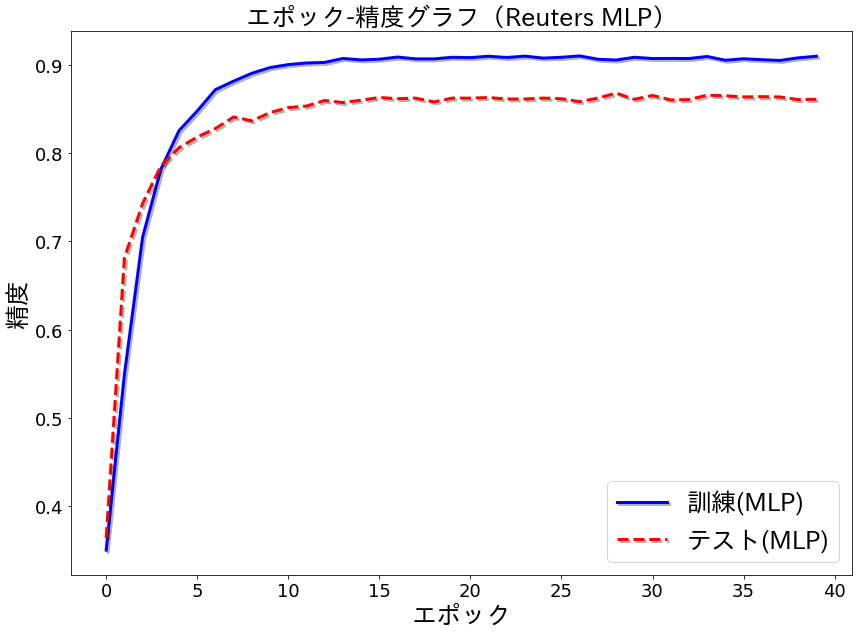

In [9]:
plt.figure(figsize=(14,10))

plt.plot(history.history['categorical_accuracy'], 
         color='b', 
         linestyle='-', 
         linewidth=3, 
         path_effects=[path_effects.SimpleLineShadow(),
                       path_effects.Normal()])
plt.plot(history.history['val_categorical_accuracy'], 
         color='r', 
         linestyle='--',
         linewidth=3,
         path_effects=[path_effects.SimpleLineShadow(),
                       path_effects.Normal()])

plt.tick_params(labelsize=18)

plt.title('エポック-精度グラフ（Reuters MLP）',fontsize=30,font_properties=fp2)
plt.ylabel('精度',fontsize=25, font_properties=fp2)
plt.xlabel('エポック',fontsize=25, font_properties=fp2)
plt.legend(['訓練(MLP)', 'テスト(MLP)'], loc='best', fontsize=25, prop=fp2)

plt.savefig('pdf/EpochAcc-Reuters-MLP-2019-7-28.pdf')
plt.savefig('images/EpochAcc-Reuters-MLP-2019-7-28.jpg')
plt.show()

## 損失についての可視化と表示

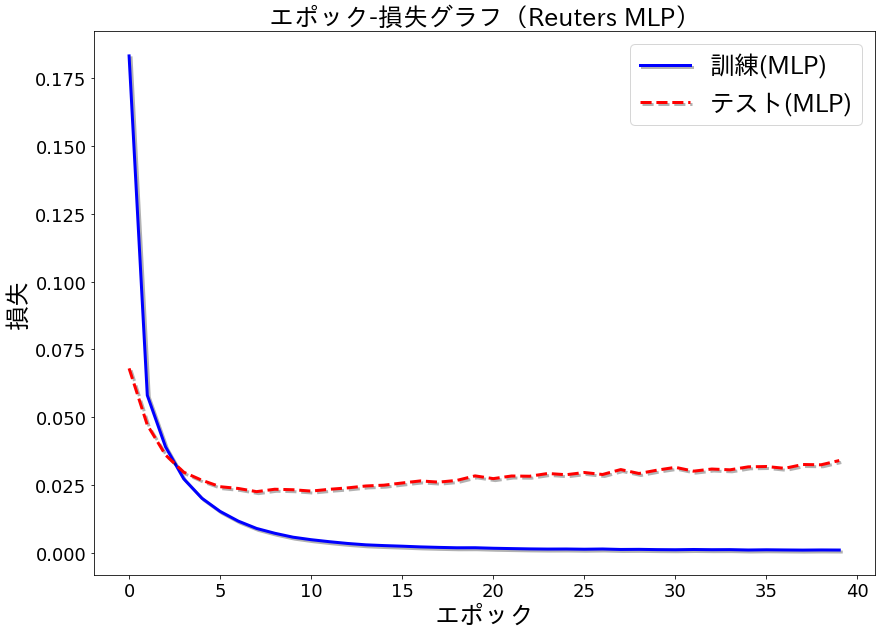

In [10]:
plt.figure(figsize=(14,10))

plt.plot(history.history['loss'], 
         color='b', 
         linestyle='-', 
         linewidth=3, 
         path_effects=[path_effects.SimpleLineShadow(),
                       path_effects.Normal()])
plt.plot(history.history['val_loss'], 
         color='r', 
         linestyle='--',
         linewidth=3,
         path_effects=[path_effects.SimpleLineShadow(),
                       path_effects.Normal()])

plt.tick_params(labelsize=18)

plt.title('エポック-損失グラフ（Reuters MLP）',fontsize=30,font_properties=fp2)
plt.ylabel('損失',fontsize=25, font_properties=fp2)
plt.xlabel('エポック',fontsize=25, font_properties=fp2)
plt.legend(['訓練(MLP)', 'テスト(MLP)'], loc='best', fontsize=25, prop=fp2)

plt.savefig('pdf/EpochLoss-Reuters-MLP-2019-7-28.pdf')
plt.savefig('images/EpochLoss-Reuters-MLP-2019-7-28.jpg')
plt.show()

## モデルの履歴の保存

In [11]:
# Save model1 and history1
model.save_weights('h5/MA_Reuters-MLP-2019-7-28-weights.h5')
model.save('h5/MA_Reuters-MLP-2019-7-28.h5')

import pickle
with open('pkl/MA_Reuters-MLP-2019-7-28.pkl', 'wb') as h_file:
    pickle.dump(history.history, h_file)

json_str = model.to_json()
open('json/MA_Reuters-MLP-2019-7-28.json','w').write(json_str)

2444

## ロードとテストデータの損失

In [12]:
# load json and create model
from keras.models import model_from_json
json_file = open('json/MA_Reuters-MLP-2019-7-28.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)

# load weights into new model
loaded_model.load_weights("mlp-weights.07-0.0114-0.0229.hdf5")
print("Loaded the best model from disk")
 
loaded_model.compile(
    optimizer="adam", # sgd, # "adadelta", # sgd, # 'adadelta', # sgd, # "adadelta", 
    loss="binary_crossentropy",
    metrics=["categorical_accuracy"])

score = loaded_model.score = loaded_model.evaluate(vectorised_test_documents, test_labels, verbose=0)

#print('Test loss:', np.round(score[0],4))
#print('Test accuracy:', np.round(score[1],4))
print()
print("\nテストデータの損失: {:.4f} (カテゴリカル精度: {:.3f}) ".format(score[0], score[1]))

Loaded the best model from disk


テストデータの損失: 0.0229 (カテゴリカル精度: 0.830) 


## MLP

In [13]:
# TF-IDFモデルでベクトル化したデータをMLPで予測したときの確率
preds = model.predict(vectorised_test_documents)
print(preds.shape)
total = vectorised_test_documents.shape[0]

THRESHOLD = 0.2 # 閾値
# MLPでの予測カテゴリーを就農する変数を用意
pred_class = np.zeros((total,NUM_CLASSES),dtype=int)
for i in range(total):
    array = np.array(preds[i])
    for j in range(NUM_CLASSES):
        if (array[j] > THRESHOLD):
            pred_class[i][j] = 1
        else:
            pred_class[i][j] = 0
            
    value = (OVR_predictions[i] == pred_class[i]).all()
    if value == False:
        print("No.",i)
        print("Ground Truth")
        print(test_labels[i])
        print("Machine Learning (SVM)")
        print(OVR_predictions[i])
        print("MLP")
        print(pred_class[i])
        for j in range(NUM_CLASSES):
            if (test_labels[i,j]==1):
                print(categories[j])
        print("------------------------------")

(2987, 55)
No. 1
Ground Truth
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Machine Learning (SVM)
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
MLP
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
grain
------------------------------
No. 2
Ground Truth
[0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Machine Learning (SVM)
[0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
MLP
[0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
crude
nat-gas
------------------------------
No. 6
Ground Truth
[0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0
 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0]
Machi

 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
crude
gas
------------------------------
No. 265
Ground Truth
[0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Machine Learning (SVM)
[0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
MLP
[0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
crude
gas
------------------------------
No. 275
Ground Truth
[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Machine Learning (SVM)
[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
MLP
[1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
acq
------------------------------
No. 278
Ground Truth
[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
trade
------------------------------
No. 547
Ground Truth
[0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 0 0 0 0 1 1 0 0 0]
Machine Learning (SVM)
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
MLP
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
cotton
grain
meal-feed
oilseed
soy-meal
soy-oil
soybean
veg-oil
wheat
------------------------------
No. 550
Ground Truth
[0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Machine Learning (SVM)
[0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0]
MLP
[0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0]
corn
grain
------------------------------
No. 554


 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
dlr
------------------------------
No. 760
Ground Truth
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Machine Learning (SVM)
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
MLP
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0]
gnp
------------------------------
No. 768
Ground Truth
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Machine Learning (SVM)
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
MLP
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
money-fx
------------------------------
No. 769
Ground Truth
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 

No. 1192
Ground Truth
[0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Machine Learning (SVM)
[0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
MLP
[0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0]
dlr
------------------------------
No. 1194
Ground Truth
[0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Machine Learning (SVM)
[0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
MLP
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
dlr
money-fx
------------------------------
No. 1205
Ground Truth
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Machine Le

No. 1459
Ground Truth
[1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Machine Learning (SVM)
[1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
MLP
[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
acq
cocoa
------------------------------
No. 1465
Ground Truth
[0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Machine Learning (SVM)
[0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
MLP
[1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
dlr
money-fx
------------------------------
No. 1466
Ground Truth
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Mach

------------------------------
No. 1671
Ground Truth
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0]
Machine Learning (SVM)
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0]
MLP
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0]
grain
rice
sugar
------------------------------
No. 1677
Ground Truth
[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Machine Learning (SVM)
[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
MLP
[1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
acq
------------------------------
No. 1684
Ground Truth
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 

No. 1881
Ground Truth
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Machine Learning (SVM)
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
MLP
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
interest
money-fx
------------------------------
No. 1887
Ground Truth
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Machine Learning (SVM)
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
MLP
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
ship
------------------------------
No. 1893
Ground Truth
[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Mach

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Machine Learning (SVM)
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
MLP
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
money-supply
------------------------------
No. 2220
Ground Truth
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Machine Learning (SVM)
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
MLP
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0]
money-fx
------------------------------
No. 2222
Ground Truth
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Machine Learning (SVM)
[0 0

Ground Truth
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0]
Machine Learning (SVM)
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
MLP
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
oilseed
soybean
------------------------------
No. 2710
Ground Truth
[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Machine Learning (SVM)
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
MLP
[0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
acq
------------------------------
No. 2728
Ground Truth
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Machine Learning

## 単語から辞書の作成

In [14]:
# ニュース記事に現れる単語→インデックス辞書の作成
import numpy as np
from nltk import word_tokenize
import collections
import re
 
maxlen = 20 # 1文書に含まれる層単語数の上限を保持
min_length = 3 # 1単語の文字数の最小値(3文字以上の単語のみ残す)
word_counter = collections.Counter()
docs = [train_docs, test_docs]

for document in docs: # 単語の小文字化と抽出
    num_data = len(document)
    for i in range(num_data):
        text = document[i]
        words = map(lambda word: word.lower(), word_tokenize(text))
        p = re.compile('[a-zA-Z]+')
        filtered_tokens = list(filter (lambda token: p.match(token) and len(token) >= min_length, words))
        if len(filtered_tokens) > maxlen:
            maxlen = len(filtered_tokens)
        for word in filtered_tokens:
            word_counter[word] += 1

print("maxlen = ",maxlen)
print(" Word count = ", len(word_counter),' ',type(word_counter))

maxlen =  1094
 Word count =  32662   <class 'collections.Counter'>


## 語彙の生成

In [15]:
print("語彙生成 creating vocabulary...")
VOCAB_SIZE = 25000 # Reuters News 最大語彙の設定（これ以上は無視する）
word2index = collections.defaultdict(int)
for wid, word in enumerate(word_counter.most_common(VOCAB_SIZE)):# 頻度順
    word2index[word[0]] = wid + 1
vocab_sz = len(word2index) + 1
index2word = {v:k for k, v in word2index.items()}
index2word[0] = "_UNK_" # 未知語
print("len(word2index) = ", len(word2index))
print("index2word[1] = ",index2word[1])

語彙生成 creating vocabulary...
len(word2index) =  25000
index2word[1] =  the


## 訓練用データの単語列の生成

In [16]:
from keras.preprocessing.sequence import pad_sequences
from keras.utils import np_utils
from nltk.corpus import stopwords

print("訓練用データの単語列生成 creating word sequences...")

min_length = 3
cachedStopWords = stopwords.words("english")

xs_train = []
document = train_docs
num_data = len(document)
for i in range(num_data):
    text = document[i]
    words = [x.lower() for x in word_tokenize(text)] # NLTK's word tokenizer
    words = [word for word in words if word not in cachedStopWords]
    p = re.compile('[a-zA-Z]+')
    filtered_tokens = list(filter (lambda token: p.match(token) and len(token) >= min_length, words))
    wids = [word2index[word] for word in filtered_tokens]
    xs_train.append(wids)
            
X_train = pad_sequences(xs_train, maxlen=maxlen)# パディング (1861単語が最大)
Y_train = train_labels # np_utils.to_categorical(ys)  多値分類なのでワンホットではない!!
print("訓練データ（データ＋ラベル）")
print("X_train",X_train.dtype," ",type(X_train)," ",X_train.shape)
print("Y_train",Y_train.dtype," ",type(Y_train)," ",Y_train.shape)

print("テスト用データの単語列生成 creating word sequences...")
xs_test = []
document = test_docs
num_data = len(document)
for i in range(num_data):
    text = document[i]
    words = [x.lower() for x in word_tokenize(text)] # NLTK's word tokenizer
    words = [word for word in words if word not in cachedStopWords]
    p = re.compile('[a-zA-Z]+')
    filtered_tokens = list(filter (lambda token: p.match(token) and len(token) >= min_length, words))
    wids = [word2index[word] for word in filtered_tokens]
    # wids = [word2index[word] for word in words]
    xs_test.append(wids)

X_test = pad_sequences(xs_test, maxlen=maxlen)# パディング
Y_test = test_labels # np_utils.to_categorical(ys) 多値分類なのでワンホットではない!!
print("テストデータ（データ＋ラベル）")
print("X_test",X_test.dtype," ",type(X_test)," ",X_test.shape)
print("Y_test",Y_test.dtype," ",type(Y_test)," ",Y_test.shape)

訓練用データの単語列生成 creating word sequences...
訓練データ（データ＋ラベル）
X_train int32   <class 'numpy.ndarray'>   (7713, 1094)
Y_train int32   <class 'numpy.ndarray'>   (7713, 55)
テスト用データの単語列生成 creating word sequences...
テストデータ（データ＋ラベル）
X_test int32   <class 'numpy.ndarray'>   (2987, 1094)
Y_test int32   <class 'numpy.ndarray'>   (2987, 55)


## モデルの取得

In [17]:
Xtrain = X_train
Xtest = X_test
Ytrain = Y_train
Ytest = Y_test
print(Xtrain.shape, Xtest.shape, Ytrain.shape, Ytest.shape)

# 分散表現モデル
WORD2VEC_MODEL = "C:/Users/icduser/Downloads/GoogleNews-vectors-negative300.bin.gz"

# 最大語彙サイズ
VOCAB_SIZE = 27000 

# Google Newsで学習された300次元のword embedding(分散表現)
EMBED_SIZE = 300 

(7713, 1094) (2987, 1094) (7713, 55) (2987, 55)


## 逆引き辞書の作成

In [21]:
from gensim.models import KeyedVectors
word2vec = KeyedVectors.load_word2vec_format(WORD2VEC_MODEL, binary=True)
embedding_weights = np.zeros((vocab_sz, EMBED_SIZE))
for word, index in word2index.items():
    try:
        embedding_weights[index, :] = word2vec[word]
    except KeyError:
        pass

print("Embedding_weight matrix size = ", embedding_weights.shape)

Embedding_weight matrix size =  (25001, 300)
